<a href="https://colab.research.google.com/github/AkshayJS/CS6400-Thesis-on-COVID-19-detection-based-on-Chest-X-ray-images/blob/main/Implementation_of_Unet%2B%2B_architecture_on_COVID_19_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Unet++ Architecture and assessment on COVID-19 using Chest-Xray segmentation analysis

<!--![qata](https://181fde73e78a.ngrok.io/static/imgs/banner.png)-->
![qata](https://c1df151ac00c.ngrok.io/static/imgs/banner.png)

## Importing dataset

*   The dataset is taken from Kaggle repository **[QaTa-COV19](https://www.kaggle.com/aysendegerli/qatacov19-dataset)** 

In [1]:
import os
from google.colab import drive

# Mount the google drive
drive.mount('/content/gdrive')

# Setting the environment path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

!kaggle datasets download -d aysendegerli/qatacov19-dataset

Mounted at /content/gdrive
100% 4.79G/4.79G [01:47<00:00, 70.7MB/s]
100% 4.79G/4.79G [01:47<00:00, 47.9MB/s]


In [2]:
#unzipping the zip files and deleting the zip files
!unzip -q \*.zip  && rm *.zip

## EDA:

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

path_chestXrayImages = "/content/QaTa-COV19/QaTa-COV19/Images"
path_groundTruthImages = "/content/QaTa-COV19/QaTa-COV19/Ground-truths"

chest_ids = next(os.walk(path_chestXrayImages))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids))

ground_truths_ids = next(os.walk(path_groundTruthImages))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids))

im = Image.open(os.path.join(path_chestXrayImages,chest_ids[0]))
width, height = im.size
print("Size of chest truth Image:({},{})".format(width,height))

im = Image.open(os.path.join(path_groundTruthImages,ground_truths_ids[0]))
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

plt.bar(['chest_ids','ground_truths_ids'],[len(chest_ids),len(ground_truths_ids)])

NameError: ignored

No. of chest images =  4603
No. of ground truth images =  2961
Size of chest truth Image:(224,224)
Size of Ground truth Image:(224,224)


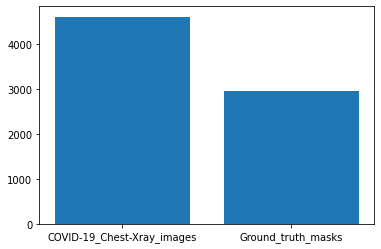

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os

path_chestXrayImages = "/content/drive/MyDrive/CS6400 - Covid Detection/QaTa-COV19/QaTa-COV19/Images"
path_groundTruthImages = "/content/drive/MyDrive/CS6400 - Covid Detection/QaTa-COV19/QaTa-COV19/Ground-truths"

chest_ids_2 = next(os.walk(path_chestXrayImages))[2] # list of names all images in the given path
print("No. of chest images = ", len(chest_ids_2))

ground_truths_ids_2 = next(os.walk(path_groundTruthImages))[2] # list of names all images in the given path
print("No. of ground truth images = ", len(ground_truths_ids_2))

im = Image.open(os.path.join(path_chestXrayImages,chest_ids_2[0]))
width, height = im.size
print("Size of chest truth Image:({},{})".format(width,height))

im = Image.open(os.path.join(path_groundTruthImages,ground_truths_ids_2[0]))
width, height = im.size
print("Size of Ground truth Image:({},{})".format(width,height))

plt.bar(['COVID-19_Chest-Xray_images','Ground_truth_masks'],[len(chest_ids_2),len(ground_truths_ids_2)])
plt.savefig('Dataset_info.png')

In [2]:
for ids in ground_truths_ids_2:
  if ids[5:] not in chest_ids_2:
    print(ids)
    ground_truths_ids_2.remove(ids)

mask_covid_54 (1).png
mask_covid_3888 (1).png
mask_covid_283 (1).png
mask_covid_1721 (1).png
mask_covid_1735 (1).png
mask_covid_3122 (1).png
mask_covid_297 (1).png
mask_covid_2228 (1).png
mask_covid_3644 (1).png
mask_covid_3136 (1).png


In [3]:
# Splitting the data to training to train and test data
from sklearn.model_selection import train_test_split
train_id, valid_id = train_test_split(ground_truths_ids_2, test_size=0.2, random_state=42)
print(f'Dimensions of X_train: {len(train_id)}')
print(f'Dimensions of X_valid: {len(valid_id)}')

Dimensions of X_train: 2360
Dimensions of X_valid: 591


## Setting up the environment

In [4]:
# Installing albumetations library and segmentation models library
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2x8p0qcv
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2x8p0qcv
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ftai7t_d
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ftai7t_d


In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset as BaseDataset

In [6]:
# helper function for data visualization
counter = 0
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap = 'seismic', interpolation = 'bilinear')
    #plt.savefig(f'images_{counter}.png')
    plt.show()
    

In [7]:
class Dataset(BaseDataset):
    """COVID Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        image_ids (str) : ids for the each COVID images
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self,
            image_ids, 
            images_dir, 
            masks_dir,
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.ids = image_ids
        self.images_fps = [os.path.join(images_dir, image_id[5:]) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)/255.
        masks = [(mask == v) for v in [1]]
        mask = np.stack(masks, axis=-1).astype('float')

        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

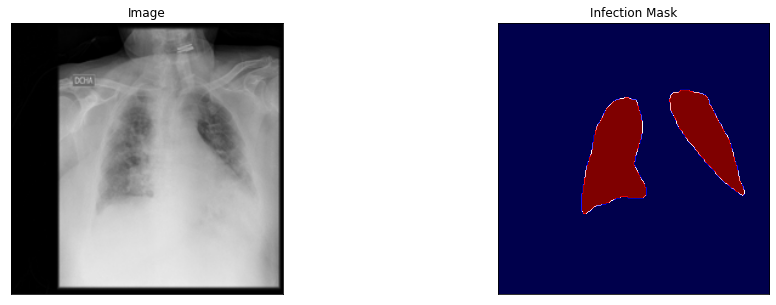

In [8]:
# Lets look at data we have

dataset = Dataset(train_id,path_chestXrayImages, path_groundTruthImages)

image, mask = dataset[3] # get some sample
visualize(
    image=image, 
    infection_mask=mask.squeeze(),
)

In [18]:
import albumentations as albu
'''
Note on Albumentation:

Albumentation is a faster and flexible library for image augmentation process.
It outperforms anyother augmentation libraries in Computer vision world 
[https://www.researchgate.net/publication/327742409_Albumentations_fast_and_flexible_image_augmentations] 

Here we perform specfic set of augmentation tasks which on relevant to chest Xrays
          Training set augmentation:
            1. Shift-Scale-Rotate : 
              Rotation: Image rotation kept at 20degrees with probability of 0.75
              Scaling: Image could be scaled with a maximum limit kept as 0.1
              Shifting: Image shifting is done with a limit of 0.1
            2. Padding:
              Padding is provided to adjust the model to perceive the lung's image

'''
def get_training_augmentation():
    
    train_transform = [

        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=0.75, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, p=1, border_mode=0),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
            ],
            p=0.9,
        )
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 320, p =0.1)
        #albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
  
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

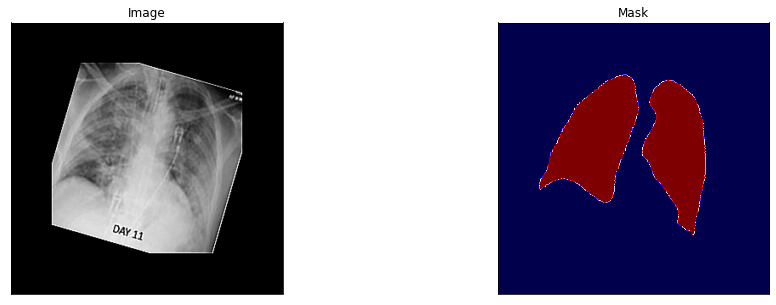

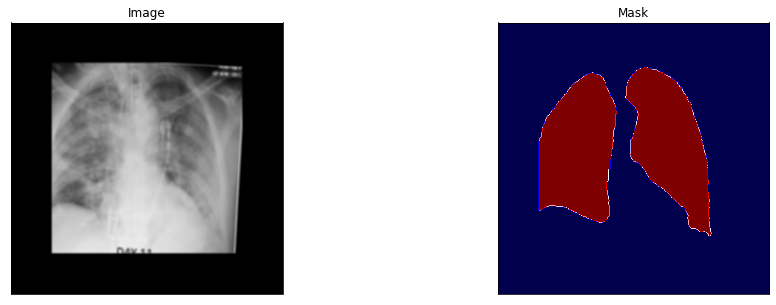

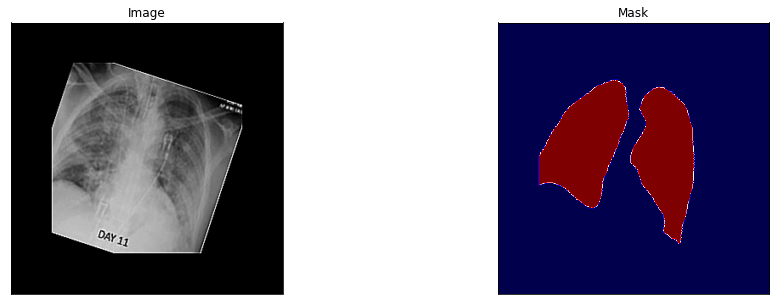

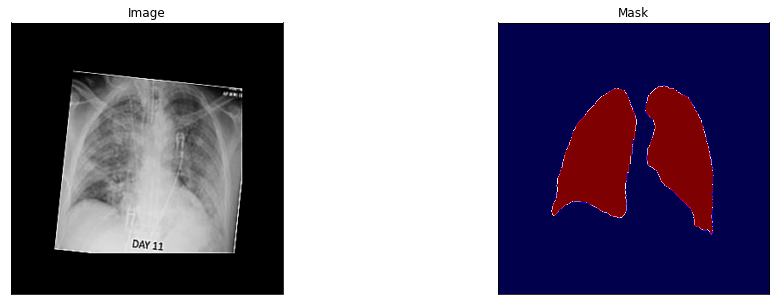

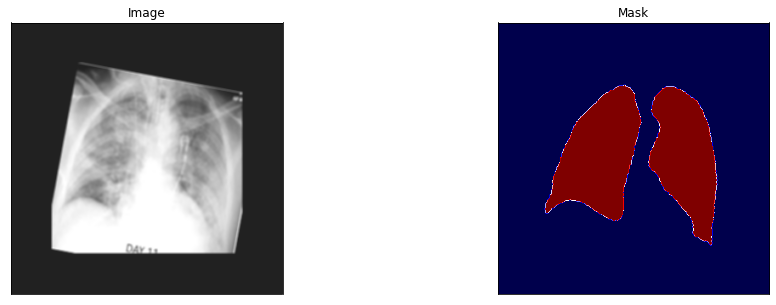

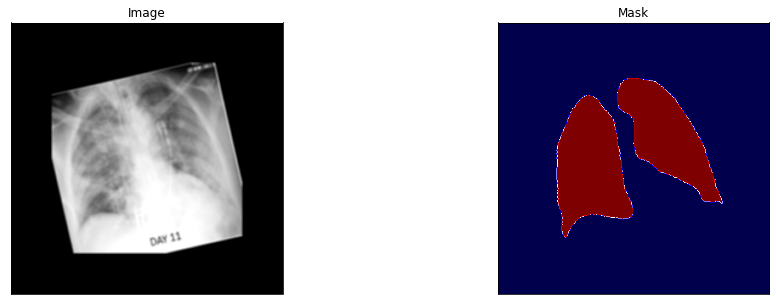

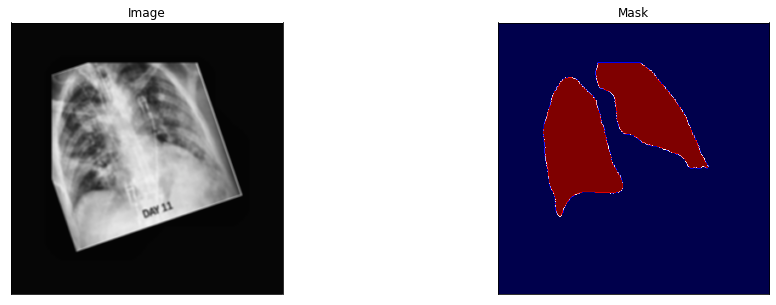

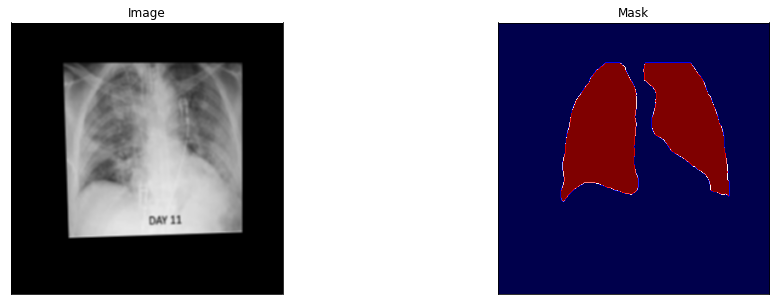

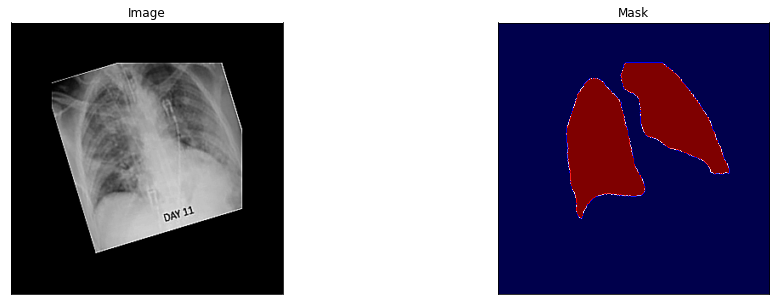

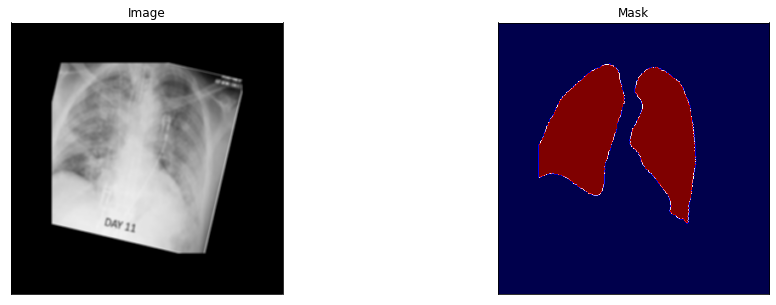

In [19]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages, 
    augmentation=get_training_augmentation(),
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[1512]
    counter = i
    visualize(image=image, mask=mask.squeeze())

In [20]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [21]:
train_dataset = Dataset(
    train_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    valid_id,path_chestXrayImages, path_groundTruthImages,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [22]:
len(train_loader)

295

In [23]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(eps = 1e-08,threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [24]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [25]:
# train model for 40 epochs

max_score = 0

for i in range(0, 20):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/295 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/591 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 591/591 [01:26<00:00,  6.84it/s, dice_loss - 0.5262, iou_score - 0.5621]
Model saved!

Epoch: 1
valid: 100%|██████████| 591/591 [00:24<00:00, 23.89it/s, dice_loss - 0.3595, iou_score - 0.5963]
Model saved!

Epoch: 2
valid: 100%|██████████| 591/591 [00:24<00:00, 23.69it/s, dice_loss - 0.3322, iou_score - 0.5667]

Epoch: 3
valid: 100%|██████████| 591/591 [00:25<00:00, 23.40it/s, dice_loss - 0.2777, iou_score - 0.6182]
Model saved!

Epoch: 4
valid: 100%|██████████| 591/591 [00:24<00:00, 23.92it/s, dice_loss - 0.2825, iou_score - 0.6123]

Epoch: 5
valid: 100%|██████████| 591/591 [00:24<00:00, 23.92it/s, dice_loss - 0.27, iou_score - 0.6215]
Model saved!

Epoch: 6
valid: 100%|██████████| 591/591 [00:24<00:00, 23.94it/s, dice_loss - 0.2975, iou_score - 0.5937]

Epoch: 7
valid: 100%|██████████| 591/591 [00:25<00:00, 23.50it/s, dice_loss - 0.2881, iou_score - 0.6052]

Epoch: 8
valid: 100%|██████████| 591/591 [00:24<00:00, 23.95it/s, dice_loss - 0.2692, iou_score - 0.618

In [26]:
best_model = torch.load('./best_model.pth')

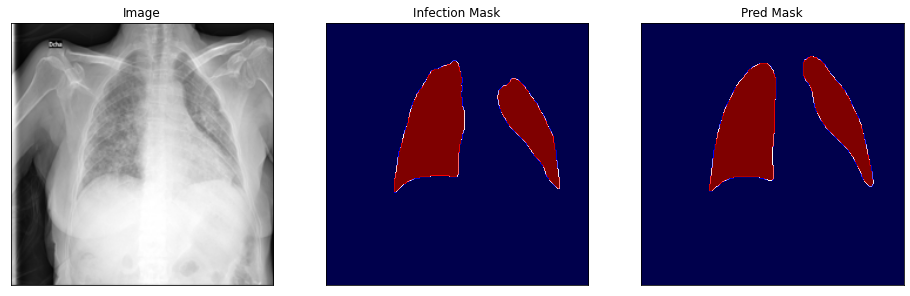

In [33]:
test = Dataset(valid_id,path_chestXrayImages, path_groundTruthImages, augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn))
test_vis = Dataset(valid_id,path_chestXrayImages, path_groundTruthImages)

k = 210
image, mask = test[k] # get some sample
image_vis, mask_vis = test_vis[k]

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

visualize(
    image=image_vis, 
    infection_mask=mask_vis.squeeze(),
    pred_mask = pr_mask
)
